In [2]:
from __future__ import print_function
import os
import cv2
import time
import json
import pickle
import pandas as pd
import scipy.io as sio
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def entropy(exp): # entropy of the explanation
    if exp.ndim == 2: # 2-d explanation. e.g. image explanation
        exp_vec = [item for exp_list in exp for item in exp_list]
    else:  # 1-d explanation. e.g., text explanation
        exp_vec = exp
    
    exp_vec = np.array(exp_vec)
    num_entries = exp_vec.size
    entropy_max = stats.entropy(np.ones(num_entries) / num_entries)
    if sum(exp_vec) == 0:
        exp_entropy = entropy_max
    else:
        exp_entropy = stats.entropy(exp_vec)
    
    return exp_entropy, entropy_max

def difficulty(exp): # intepretable difficulty of an explanation
    exp_entropy, entropy_max = entropy(exp)
    return np.exp((exp_entropy - entropy_max)/entropy_max)

def lr_reweight(exp):
    return 1/difficulty(exp)

# illustrate the learning rate reweight on CAT

In [4]:
# get the metadata
meta_path = "/home/arun/research/projects/crowdsourcing/kdd-2019/data/animal_breed_sdm/nameMapping_fullInfo_flipped0.2.mat"
data = sio.loadmat(meta_path)['nameMapping']
rows = []
for d in data:
    rows.append([x[0] for x in d.tolist()])
df = pd.DataFrame(rows, columns=['img_name','common_name','dataset','train_test','class','is_flipped'])
df.head(3)

# get the explanation of images
datasets = df['dataset'].tolist()
index_cat = [i for i,s in enumerate(datasets) if s == 'cat']
filenames = df['common_name'].tolist()
filenames_cat = [filenames[i] for i in index_cat]
exp_path = "/home/arun/Dropbox (ASU)/code_for_Arun/gradCAM/results_resnet34_cat_flipped0.2/results_all/"
pred_class = "domestic"


# calculate the learning rate reweight
for idx, filename in enumerate(filenames_cat):
    if idx >= 5:
        break
    expname = filename + "_" + pred_class + "_heatmap.png"
    exp = cv2.imread(exp_path + expname, 0)
    
    print(idx,'-th item is:', expname, '\n',
          'it has entropy of:', entropy(exp)[0], 
          ', difficulty of:', difficulty(exp), 
          ', reweight of', lr_reweight(exp) , '\n')

0 -th item is: 62PRESG3JZU8COX5TK47Q1ABVNFD90MYWILH_0003_domestic_heatmap.png 
 it has entropy of: 9.9850444885 , difficulty of: 0.925474695658 , reweight of 1.0805265716 

1 -th item is: KT9ANEOFGJ310754CRL86VSYZQDWUH2BMPXI_0005_domestic_heatmap.png 
 it has entropy of: 7.67579043899 , difficulty of: 0.747659094982 , reweight of 1.33750797216 

2 -th item is: K1ZWQLMO259C0HAVRFIB4US6D83GN7YEXTPJ_0006_domestic_heatmap.png 
 it has entropy of: 9.53348537608 , difficulty of: 0.887657295706 , reweight of 1.12656089781 

3 -th item is: ATYRM7L49XWEQPSUOK20VGDBZ86H3JI1FC5N_0007_domestic_heatmap.png 
 it has entropy of: 8.65847945649 , difficulty of: 0.818719086659 , reweight of 1.22142016266 

4 -th item is: QBW7VXRO1L0J9UMFGP5IHY48SDEK3N6TAZ2C_0012_domestic_heatmap.png 
 it has entropy of: 10.4712919925 , difficulty of: 0.968000705899 , reweight of 1.0330570979 



# illustrate the learning rate reweight on comp.vs.sci

In [8]:
from lime.lime_text import LimeTextExplainer
# get the explanation of text
exp_path = "/home/arun/Dropbox (ASU)/code_for_Arun/text_data/comp_vs_sci_flipped0.3/explanation_train_10.pickle"
exp_text = pickle.load( open(exp_path, "rb" ) )


In [14]:
%matplotlib inline
num_words = 150

exp_list = exp_text[0].as_list()[:num_words]
exp_list_value = [v for (k, v) in exp_list]
exp_list_value_abs = np.array([abs(v) for v in exp_list_value])

entropy_max = entropy(exp_list_value_abs)[1]
print('max entropy is:', entropy_max)

for idx, exp in enumerate(exp_text):
    if idx >= 5:
        break
    exp_list = exp.as_list()[:num_words]
    exp_list_value = [v for (k, v) in exp_list]
    exp_list_value_abs = np.array([abs(v) for v in exp_list_value])
    
    print(idx,'-th item is:', 'placeholder', '\n',
          'it has entropy of:', entropy(exp_list_value_abs)[0], 
          ', difficulty of:', difficulty(exp_list_value_abs), 
          ', reweight of', lr_reweight(exp_list_value_abs) , '\n')

max entropy is: 2.30258509299
0 -th item is: placeholder 
 it has entropy of: 2.28837176453 , difficulty of: 0.993846242284 , reweight of 1.00619186093 

1 -th item is: placeholder 
 it has entropy of: 2.22096051437 , difficulty of: 0.965171856287 , reweight of 1.03608491429 

2 -th item is: placeholder 
 it has entropy of: 1.92293657424 , difficulty of: 0.847996087703 , reweight of 1.17925072356 

3 -th item is: placeholder 
 it has entropy of: 2.18931319631 , difficulty of: 0.951997034054 , reweight of 1.05042344065 

4 -th item is: placeholder 
 it has entropy of: 2.21840383391 , difficulty of: 0.964100770327 , reweight of 1.0372359724 



# test the max entropy with increasing bins

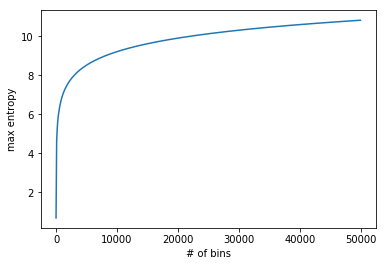

In [15]:
entropy_max = []
for ib in range(2, 50000, 100):
    pdf = np.ones(ib) * 1/ib
    entropy_max.append(stats.entropy(np.ones(ib) / ib))
plt.plot(entropy_max)
plt.xticks([0, 100, 200, 300, 400, 500], [0, 10000, 20000, 30000, 40000, 50000])
plt.xlabel('# of bins')
plt.ylabel('max entropy')
plt.show()